In [1]:
from d2l import mxnet as d2l
from mxnet import autograd, np, npx, gluon, init
from mxnet.gluon import nn

npx.set_np()

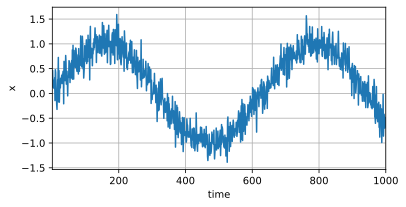

In [2]:
T = 1000  # time steps - observations
time = np.arange(1, T + 1, dtype=np.float32)
x = np.sin(0.01 * time) + np.random.normal(0, 0.2, (T,))
d2l.plot(time, [x], "time", "x", xlim=[1, 1000], figsize=(6, 3))

In [3]:
tau = 4  # limiting our observation to just last 4 - autoregressive model
features = np.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

In [4]:
batch_size, n_train = 16, 600  # Only first 600 samples will be used for training
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

In [5]:
def get_net():
    net = nn.Sequential()
    net.add(
        nn.Dense(10, activation="relu"),
        nn.Dense(1)
    )
    net.initialize(init.Xavier())
    return net


loss = gluon.loss.L2Loss()  # Square loss

In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = gluon.Trainer(net.collect_params(), "adam", {"learning_rate": lr})
    for epoch in range(epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        print(
            f"epoch: {epoch + 1}",
            f"loss: {d2l.evaluate_loss(net, train_iter, loss):f}"
        )


net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch: 1 loss: 0.037443
epoch: 2 loss: 0.033630
epoch: 3 loss: 0.028704
epoch: 4 loss: 0.027738
epoch: 5 loss: 0.027198


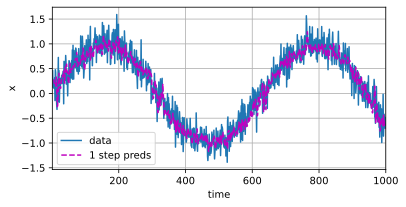

In [7]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.asnumpy(), onestep_preds.asnumpy()], "time", "x", legend=["data", "1 step preds"], xlim=[1, 1000], figsize=(6, 3))

In [9]:
# Let's try multi step prediction
multistep_pred = np.zeros(T)
multistep_pred[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_pred[i] = net(multistep_pred[i - tau: i].reshape((1, -1)))

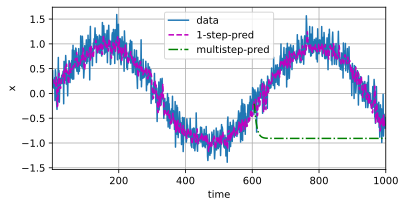

In [11]:
d2l.plot(
    [time, time[tau:], time[n_train + tau:]],
    [
        x.asnumpy(),
        onestep_preds.asnumpy(),
        multistep_pred[n_train + tau:].asnumpy()
    ],
    "time",
    "x",
    legend=["data", "1-step-pred", "multistep-pred"],
    xlim=[1, 1000],
    figsize=(6, 3)
)